In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [2]:
df_gb_freq_2018 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2018_cleansed/Nationalgrid/2018.csv", header=None, names=['timestamp', 'freq'])
# df_gb_freq_2019 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2019_cleansed/Nationalgrid/2019.csv")
# df_gb_freq_2020 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2020_cleansed/Nationalgrid/2020.csv")
# df_gb_freq_2021 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2021_cleansed/Nationalgrid/2021.csv")
# df_gb_freq_2022 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2022_cleansed/Nationalgrid/2022.csv")
# df_gb_freq_2023 = pd.read_csv("/Users/dudu/Projects/PIML-for-grid-frequency-modelling-main/data/2023_cleansed/Nationalgrid/2023.csv")

# Combine all dataframes into a single dataframe
# df_freq = pd.concat([df_gb_freq_2018, df_gb_freq_2019, df_gb_freq_2020, df_gb_freq_2021, df_gb_freq_2022, df_gb_freq_2023], ignore_index=True)

df_freq = df_gb_freq_2018


In [3]:
df_freq['timestamp'] = pd.to_datetime(df_freq['timestamp'])
df_freq['hour'] = df_freq.index.hour

In [15]:
def timestamp_to_efa_block(pd_timestamp):
    # Ensure the timestamp is timezone-aware; if not, assume it's in UTC
    if pd_timestamp.tzinfo is None:
        pd_timestamp = pd_timestamp.tz_localize('UTC')

    # Convert UTC timestamp to UK local time (handles daylight saving time)
    uk_timestamp = pd_timestamp.tz_convert('Europe/London')

    # Determine the EFA day start (23:00 UK local time)
    efa_day_start_hour = 23
    if uk_timestamp.hour >= efa_day_start_hour:
        efa_day_start = uk_timestamp.replace(hour=efa_day_start_hour, minute=0, second=0, microsecond=0)
    else:
        efa_day_start = (uk_timestamp - pd.Timedelta(days=1)).replace(hour=efa_day_start_hour, minute=0, second=0, microsecond=0)

    # Calculate the number of hours since the EFA day started
    time_diff = uk_timestamp - efa_day_start
    total_hours = time_diff.total_seconds() / 3600

    # Determine the EFA block number (each block is 4 hours long)
    efa_block = int(total_hours // 4) + 1

    # Ensure the EFA block number is between 1 and 6
    efa_block = ((efa_block - 1) % 6) + 1

    return efa_block

df_freq['efa_cat'] = df_freq['timestamp'].progress_map(timestamp_to_efa_block)

100%|████████████████████████████| 31536000/31536000 [45:22<00:00, 11581.86it/s]


In [36]:
# df_freq.to_pickle('df_freq_2018.pkl')
from scipy.stats import skew, kurtosis

df_freq = df_freq.dropna(subset=['freq'])

df_freq_agg = df_freq.groupby('efa_cat').agg({
    'freq': ['mean', 'std', kurtosis, 'skew']
})

In [45]:
df_freq_hour_agg = df_freq.groupby('hour').agg({
    'freq': ['mean', 'std', kurtosis, 'skew']
})

<Axes: xlabel='hour'>

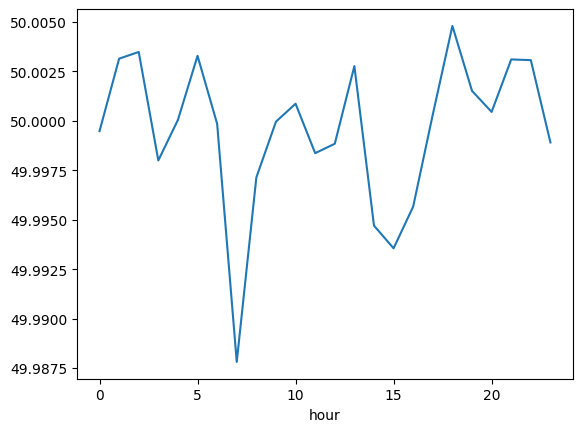

In [50]:
df_freq_hour_agg['freq']['mean'].plot()

<Axes: xlabel='hour'>

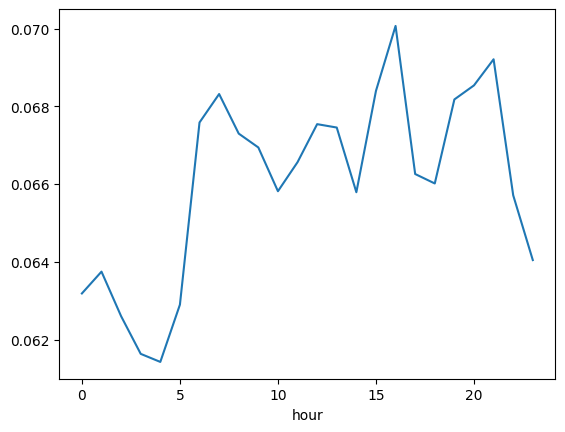

In [47]:
df_freq_hour_agg['freq']['std'].plot()

<Axes: xlabel='efa_cat'>

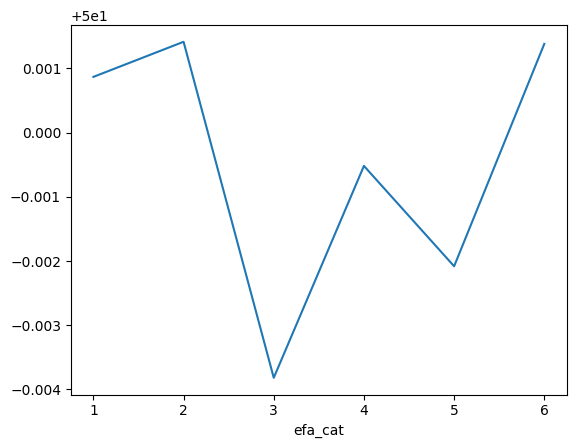

In [51]:
df_freq_agg['freq']['mean'].plot()

<Axes: xlabel='efa_cat'>

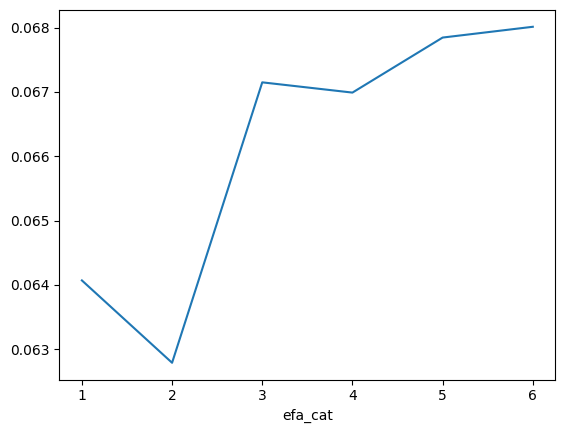

In [49]:
df_freq_agg['freq']['std'].plot()

In [22]:
df_freq[df_freq['hour']==3]

,timestamp,freq,hour,efa_cat
10800,2018-01-01 03:00:00,50.037,3,2
10801,2018-01-01 03:00:01,50.030,3,2
10802,2018-01-01 03:00:02,50.025,3,2
10803,2018-01-01 03:00:03,50.020,3,2
10804,2018-01-01 03:00:04,50.012,3,2
...,...,...,...,...
31463995,2018-12-31 03:59:55,50.045,3,2
31463996,2018-12-31 03:59:56,50.042,3,2
31463997,2018-12-31 03:59:57,50.045,3,2
31463998,2018-12-31 03:59:58,50.047,3,2


In [25]:
datetime.fromtimestamp

<function datetime.fromtimestamp>

In [20]:
df_plot = df_freq.resample('H').std()


In [28]:
# Analyse average std for each hour
df1 = df_plot.to_frame()
df1['hour'] = df1.index.hour

<Axes: xlabel='timestamp'>

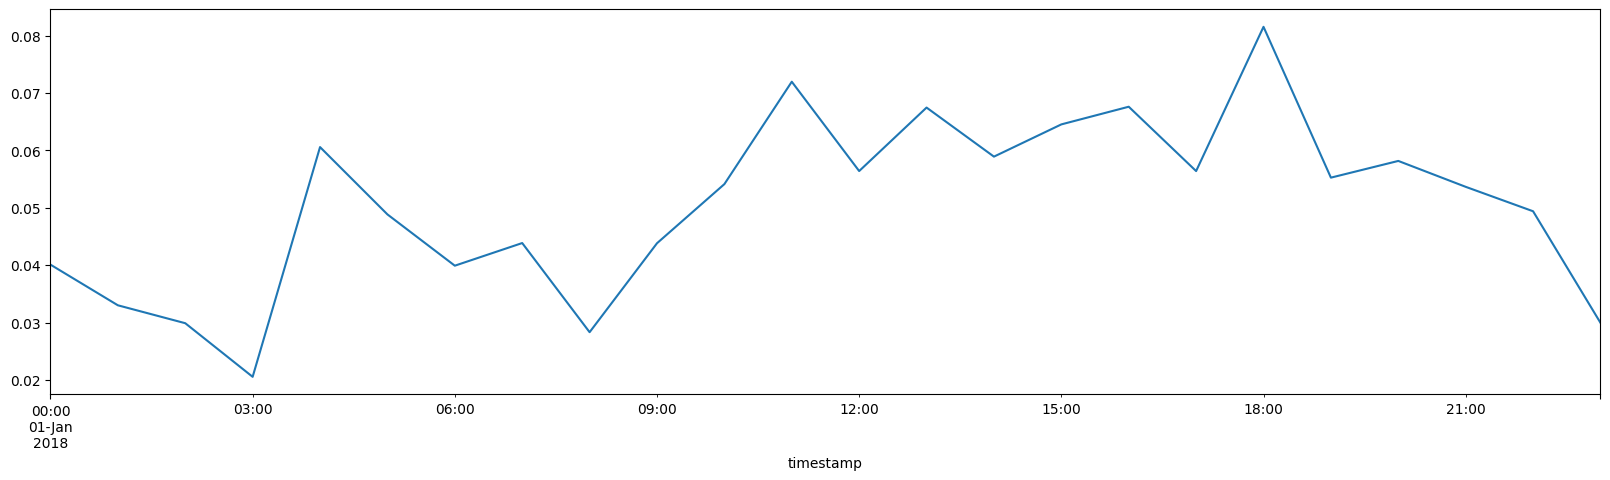

In [34]:
df_plot.head(24).plot(figsize=(20,5))

In [5]:
# Generate synthetic day-ahead features
# For simplicity, let's create features like forecasted load and temperature
hours = pd.date_range(start='2023-01-01', periods=24, freq='H')
forecasted_load = 1000 + 200 * np.sin(np.linspace(0, 2 * np.pi, 24))  # Simulated daily load curve
forecasted_temperature = 20 + 5 * np.cos(np.linspace(0, 2 * np.pi, 24))  # Simulated temperature curve

df_day_ahead = pd.DataFrame({
    'Forecasted_Load': forecasted_load,
    'Forecasted_Temperature': forecasted_temperature
}, index=hours)

# Resample frequency data to compute hourly standard deviation (target variable)
df_frequency_hourly_std = df_frequency['Frequency'].resample('H').std().rename('Freq_STD')

# Combine day-ahead features and target variable into a single DataFrame
df_features = df_day_ahead.join(df_frequency_hourly_std)

# Add real-time initial frequency (e.g., frequency at the beginning of each hour)
initial_frequency = df_frequency['Frequency'].resample('H').first().rename('Initial_Frequency')
df_features = df_features.join(initial_frequency)

# Drop any NaN values (if any)
df_features.dropna(inplace=True)

Root Mean Squared Error: 0.00030


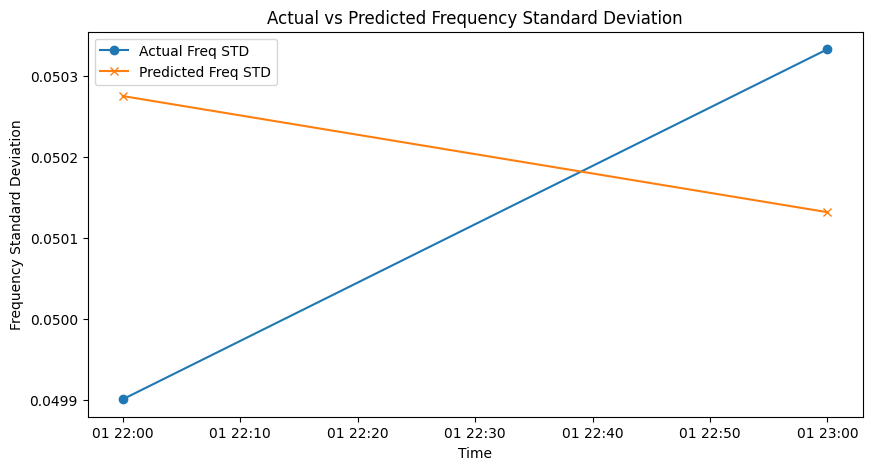

In [6]:
# Feature matrix X and target vector y
X = df_features[['Forecasted_Load', 'Forecasted_Temperature', 'Initial_Frequency']]
y = df_features['Freq_STD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/24, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.5f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual Freq STD', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Freq STD', marker='x')
plt.xlabel('Time')
plt.ylabel('Frequency Standard Deviation')
plt.title('Actual vs Predicted Frequency Standard Deviation')
plt.legend()
plt.show()

RMSE for Frequency STD: 0.00030
RMSE for Frequency Skew: 0.01881


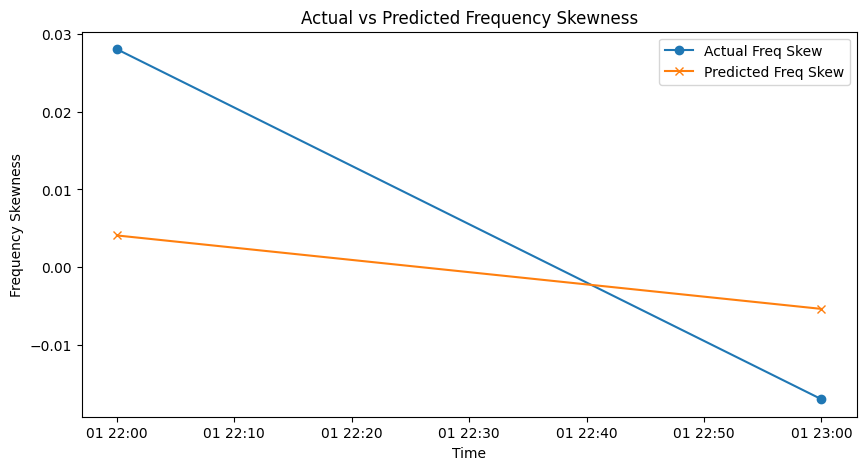

In [7]:
# If third level momentum is required, define it (e.g., skewness)
# Here, let's define third level momentum as skewness of frequency in each hour
from scipy.stats import skew

df_frequency_hourly_skew = df_frequency['Frequency'].resample('H').apply(skew).rename('Freq_Skew')
df_features['Freq_Skew'] = df_frequency_hourly_skew

# Update target variable to include Freq_Skew
y_multi = df_features[['Freq_STD', 'Freq_Skew']].dropna()
X_multi = df_features[['Forecasted_Load', 'Forecasted_Temperature', 'Initial_Frequency']].loc[y_multi.index]

# Split the data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=2/24, shuffle=False)

# Standardize features
X_train_m_scaled = scaler.fit_transform(X_train_m)
X_test_m_scaled = scaler.transform(X_test_m)

# Train a model for multi-output regression
from sklearn.multioutput import MultiOutputRegressor

multi_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multi_model.fit(X_train_m_scaled, y_train_m)

# Predict on the test set
y_pred_m = multi_model.predict(X_test_m_scaled)

# Evaluate the model
rmse_std = np.sqrt(mean_squared_error(y_test_m['Freq_STD'], y_pred_m[:, 0]))
rmse_skew = np.sqrt(mean_squared_error(y_test_m['Freq_Skew'], y_pred_m[:, 1]))
print(f"RMSE for Frequency STD: {rmse_std:.5f}")
print(f"RMSE for Frequency Skew: {rmse_skew:.5f}")

# Plot actual vs predicted for Freq_Skew
plt.figure(figsize=(10, 5))
plt.plot(y_test_m.index, y_test_m['Freq_Skew'].values, label='Actual Freq Skew', marker='o')
plt.plot(y_test_m.index, y_pred_m[:, 1], label='Predicted Freq Skew', marker='x')
plt.xlabel('Time')
plt.ylabel('Frequency Skewness')
plt.title('Actual vs Predicted Frequency Skewness')
plt.legend()
plt.show()